# HOUSE ROCKET PROJECT - INSIGHTS

## Business Problem and Solution Plan

House Rocket is a real state company whose model consist in identifying good properties with a good price and futurely sold for a higher price aiming to maximize profit. For this case, we will be operating on King Country.

**1 Problem - Which houses should House Rocket buy?**

To solve this problem firstly we need to agroup the houses by their location (zipcode), because we know in advance that location is a very influencial feature on the price of the houses.

Then we will take the median price for each one of the zipcodes and build a table of recomendation respecting the following rules:

- The price has to be lower than the median of the region;
- The house must be in good conditions, which means condition >= 3

As for suggested price, we will take into account the density of the region, which means that regions that have more houses to sell, it is viable to offer lower prices. Therefore the rule we will follow is:

- From 0 to 204 properties in the region => Offer the asked price
- From 205 to 282 properties in the region => Offer 3% less than the asked price
- From 283 to 408 properties in the region => Offer 5% less than the asked price
- From 409 properties upwards => Offer 7% less than the asked price

**2 Problem - After we buy a house, for which price should it be sold?**

To suggest a sell price, again the density by region will be considered, since for regions where the number of real estate ads is lower it's possible to sell the property for a higher price, and vice-versa. Hence, a reasonable rule for suggested sell prices is:

- From 0 to 204 properties in the region => Sell for 15% than the suggested buy price
- From 205 to 282 properties in the region => Sell for 14% than the suggested buy price
- From 283 to 408 properties in the region => Sell for 12% than the suggested buy price
- From 409 properties upwards => Sell for 10% than the suggested buy price

# 0. IMPORTS

In [1]:
# Imports

import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim
import plotly.express as px
from IPython.display import Image
import seaborn as sns
from IPython.core.display import HTML
from matplotlib import pyplot as plt

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 10
   

    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

## 0.1 Helper Functions

In [3]:
# Functions


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 10
   

    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    


def show_dimensions( data ):
    print('Number of Rows: {}'.format(data.shape[0]))
    print('Number of Columns: {}'.format(data.shape[1]))
    
    return None


def descriptive_statistics( data ):
    # descriptive statistics
    num_attributes = data.select_dtypes( include=['int64', 'float64'] )

    # central tendency
    media = pd.DataFrame( num_attributes.apply( np.mean ) )
    mediana = pd.DataFrame( num_attributes.apply( np.median ) )
    std = pd.DataFrame( num_attributes.apply( np.std ) )

    # dispersion
    std = pd.DataFrame( num_attributes.apply( np.std ) )
    max_ = pd.DataFrame( num_attributes.apply( np.max ) )
    min_ = pd.DataFrame( num_attributes.apply( np.min ) )

    df1 = pd.concat( [max_, min_, media, mediana, std ], axis=1 ).reset_index()
    df1.columns = ['attributes', 'mean', 'median', 'std', 'max', 'min']
    
    return df1


def create_new_attributes( data, geodata=False ):
    #Crie uma nova coluna chamada: “house_age”
    data.loc[data['date'] > pd.to_datetime( '2014-01-01' ), 'house_age'] = 'new_house'
    data.loc[data['date'] < pd.to_datetime( '2014-01-01' ), 'house_age'] = 'old_house'


    # Crie uma nova coluna chamada: “dormitory_type”
    for i in range( len( data ) ):
        if data.loc[i, 'bedrooms'] == 1:
            data.loc[i, 'dormitory_type'] = 'studio'

        elif data.loc[i, 'bedrooms'] == 2:
            data.loc[i, 'dormitory_type'] = 'apartment'

        else:
            data.loc[i, 'dormitory_type'] = 'house'

    # define level of prices
    for i in range( len( data ) ):
        if data.loc[i, 'price'] <= 321950:
            data.loc[i, 'level'] = 0

        elif ( data.loc[i,'price'] > 321950 ) & ( data.loc[i,'price'] <= 450000 ):
            data.loc[i, 'level'] = 1

        elif ( data.loc[i,'price'] > 450000 ) & ( data.loc[i,'price'] <= 645000 ):
            data.loc[i, 'level'] = 2

        else:
            data.loc[i, 'level'] = 3
            
    if geodata == True:
        # initialize API
        geolocator = Nominatim( user_agent='geopiExercises' )

        # only 10 rows
        data = data.head(10)

        # Create empty rows
        data.loc[:, 'road'] = 'NA'
        data.loc[:, 'house_number'] = 'NA'
        data.loc[:, 'city'] = 'NA'
        data.loc[:, 'county'] = 'NA'
        data.loc[:, 'state'] = 'NA'

        for i in range( len( data ) ):
            print( 'Loop: {}/{}'.format( i, len( data ) ) )
            # make request
            query = str( data.loc[i, 'lat'] ) + ',' + str( data.loc[i, 'long'] )
            response = geolocator.reverse( query )

            # parse data
            if 'house_number' in response.raw['address']:
                data.loc[i, 'house_number'] = response.raw['address']['house_number']

            if 'road' in response.raw['address']:
                data.loc[i, 'road'] = response.raw['address']['road']

            if 'city' in response.raw['address']:
                data.loc[i, 'city'] = response.raw['address']['city']

            if 'county' in response.raw['address']:
                data.loc[i, 'county'] = response.raw['address']['county']

            if 'state' in response.raw['address']:
                data.loc[i, 'state'] = response.raw['address']['state']
            
    return data


def draw_map( data ):
    # map
    houses = data[['id', 'lat', 'long', 'price', 'level']].copy()
    fig = px.scatter_mapbox( houses, 
                             lat="lat", 
                             lon="long", 
                             color="level", 
                             size="price",
                             color_continuous_scale=px.colors.cyclical.IceFire, 
                             size_max=15, 
                             zoom=10)

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(height=600, margin={"r":0,"t":0,"l":0,"b":0})
    
    return fig




# if __name__ == "__main__":
    # ==================
    # Extraction
    # ==================
    # load dataset
#    data = pd.read_csv( 'C:/Users/Pedro/repos/python_zeroaods/datasets/kc_house_data.csv' )
#    show_dimensions( data )

    # ==================
    # Transformation
    # ==================
    # convert object to date
#    data['date'] = pd.to_datetime( data['date'] )

    # make descriptive analysis
#    descriptive_statistics( data )

    # create new attributes
#    create_new_attributes( data, geodata=False )

    # ==================
    # Load
    # ==================
    # draw a map
#    fig = draw_map( data )
#    fig.show()

In [20]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 1.0 DATA DESCRIPTION

## 1.1 Loading Data

In [4]:
# Carregando o DataSet

data_raw = pd.read_csv('C:/Users/Pedro/Desktop/Data Science/Comunidade DS/Python Zero ao DS/House Rocket/datasets/kc_house_data.csv')
df1 = data_raw.copy()

## 1.2 Organizando as Colunas

In [5]:
df1 = df1.loc[:, ~df1.columns.isin(['sqft_living15', 'sqft_lot15'] )]
df1.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long'],
      dtype='object')

## 1.3 Dimensão do Dataset

In [6]:
show_dimensions(df1)

Number of Rows: 21613
Number of Columns: 19


## 1.4 Data Types

In [7]:
df1.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
dtype: object

## 1.5 Change Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1 = df1.astype({'bathrooms':int}, errors='raise')
df1['bathrooms'] = df1['bathrooms'].astype(  np.int64  )
df1.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms                 int64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
dtype: object

## 1.6 Check NA

In [9]:
df1.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
dtype: int64

## 1.7 Descrição Estatistica

In [10]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

In [11]:
# Central Tendency - mean, median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# Concat
pd.set_option('display.float_format', lambda x: '%.3f' % x)
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1000102.000,9900000190.000,9899000088.000,4580301520.865,3904930410.000,2876499023.428,0.243,-1.261
1,price,75000.000,7700000.000,7625000.000,540088.142,450000.000,367118.703,4.024,34.586
2,bedrooms,0.000,33.000,33.000,3.371,3.000,0.930,1.974,49.064
3,bathrooms,0.000,8.000,8.000,1.750,2.000,0.735,0.902,1.990
4,sqft_living,290.000,13540.000,13250.000,2079.900,1910.000,918.420,1.472,5.243
5,sqft_lot,520.000,1651359.000,1650839.000,15106.968,7618.000,41419.553,13.060,285.078
6,floors,1.000,3.500,2.500,1.494,1.500,0.540,0.616,-0.485
7,waterfront,0.000,1.000,1.000,0.008,0.000,0.087,11.385,127.632
8,view,0.000,4.000,4.000,0.234,0.000,0.766,3.396,10.893
9,condition,1.000,5.000,4.000,3.409,3.000,0.651,1.033,0.526


# 2.0 FEATURE ENGINEERING

In [76]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

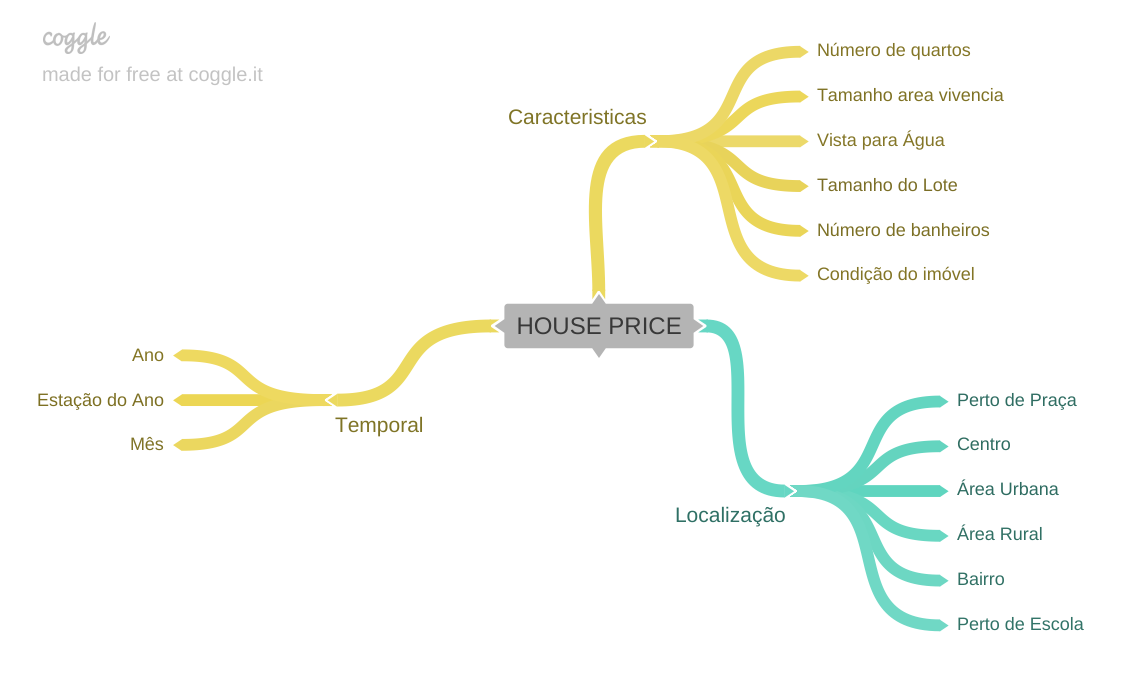

In [14]:
Image('C:/Users/Pedro/Desktop/Data Science/Comunidade DS/Python Zero ao DS/House Rocket/HOUSE_PRICE.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses de Caracteristica

**1.** Casas com mais banheiros são mais caras na média

**2.** Casas com área de vivencia maior são mais caras.

**3.** Casas com vista para água são 30% mais caras.

**4.** Casas com o tamanho do lote maior são mais caras.

**5.** Casas com mais quartos são mais caras.

**6.** Casas com a melhor condição são mais caras.

### 2.2.2 Hipóteses de Localização

**1.** Casas em áreas perto de rios ou lagos são mais caras.

**2.** Casas mais afastadas do centro são mais baratas.

**3.** Casas perto de escolas são mais caras.

### 2.2.2 Hipóteses de Tempo

**1.** Casas durante o verão são mais caras

**2.** Casas valorizam 20% a cada ano.


## 2.3 Lista Final de Hipóteses

**1.** Casas com mais banheiros são mais caras na média

**2.** Casas com área de vivencia maior são mais caras.

**3.** Casas com vista para água são 30% mais caras.

**4.** Casas com o tamanho do lote maior são mais caras.

**5.** Casas com mais quartos são mais caras.

**6.** Casas com a melhor condição são mais caras.

**7.** Casas em áreas perto de rios ou lagos são mais caras.

**8.** Casas mais afastadas do centro são mais baratas.

**9.** Casas perto de escolas são mais caras.

**10.** Casas durante o verão são mais caras

**11.** Casas valorizam 20% a cada ano.

## 2.4 Feature Engineering

In [77]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Price/sqft
df2['price_sqft_lot'] = df2['price'] / df2['sqft_lot']

C:\Users\Pedro\AppData\Local\Temp/ipykernel_14740/2566836444.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 ANÁLISE EXPLORATÓRIA DE DADOS

In [78]:
df3 = df2.copy()

## 3.1 Análise Univariada

### 3.1.1 Reponse Variable

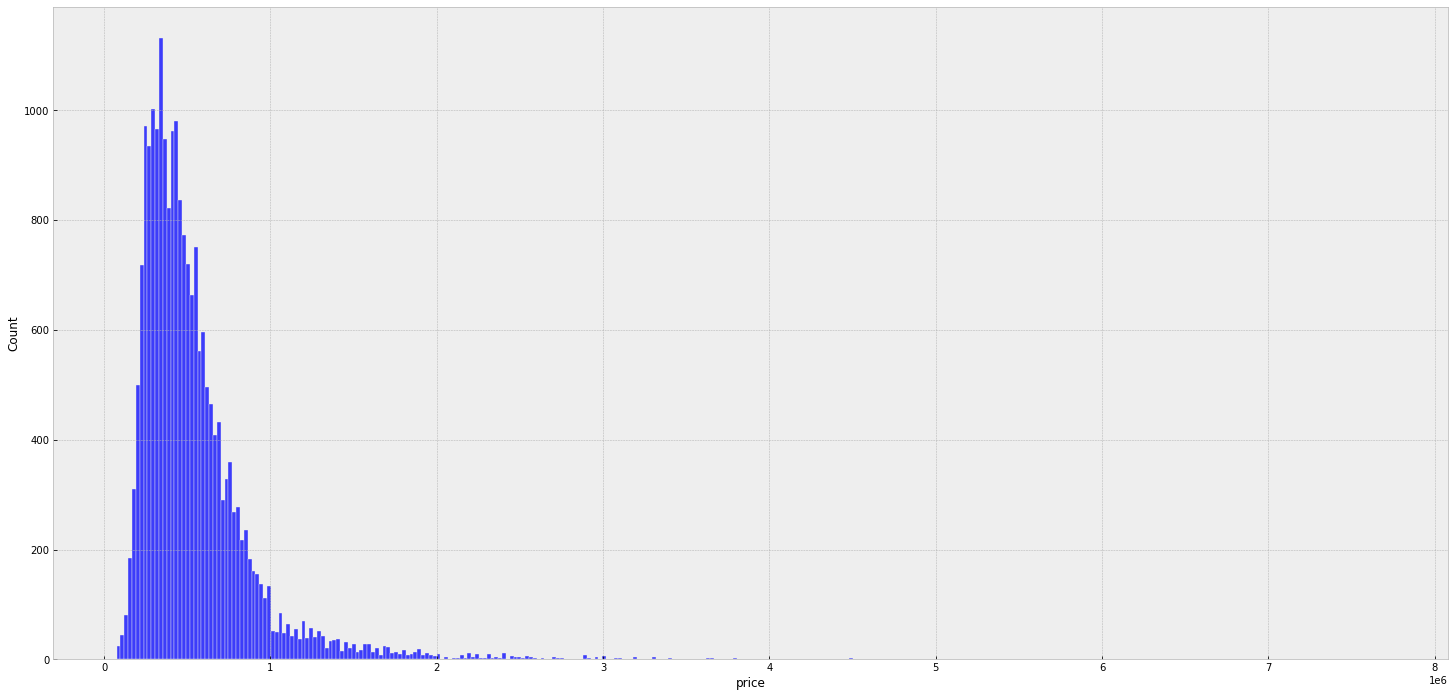

In [23]:
sns.histplot(( df3['price']) );

### 3.1.2 Numerical Variable

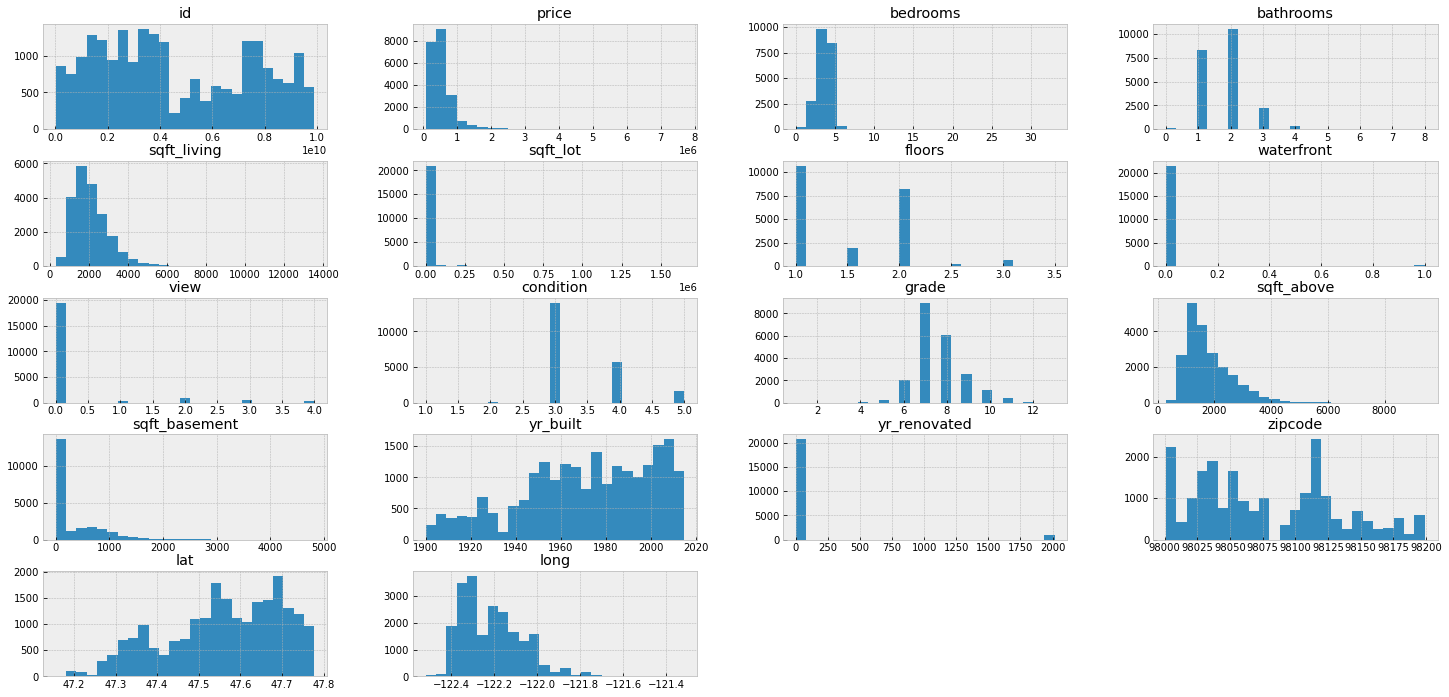

In [25]:
num_attributes.hist(bins=25);

## 3.2 Análise Bivariada

### **1.**  Casas com mais banheiros são mais caras na média
**Verdadeiro**

<AxesSubplot:>

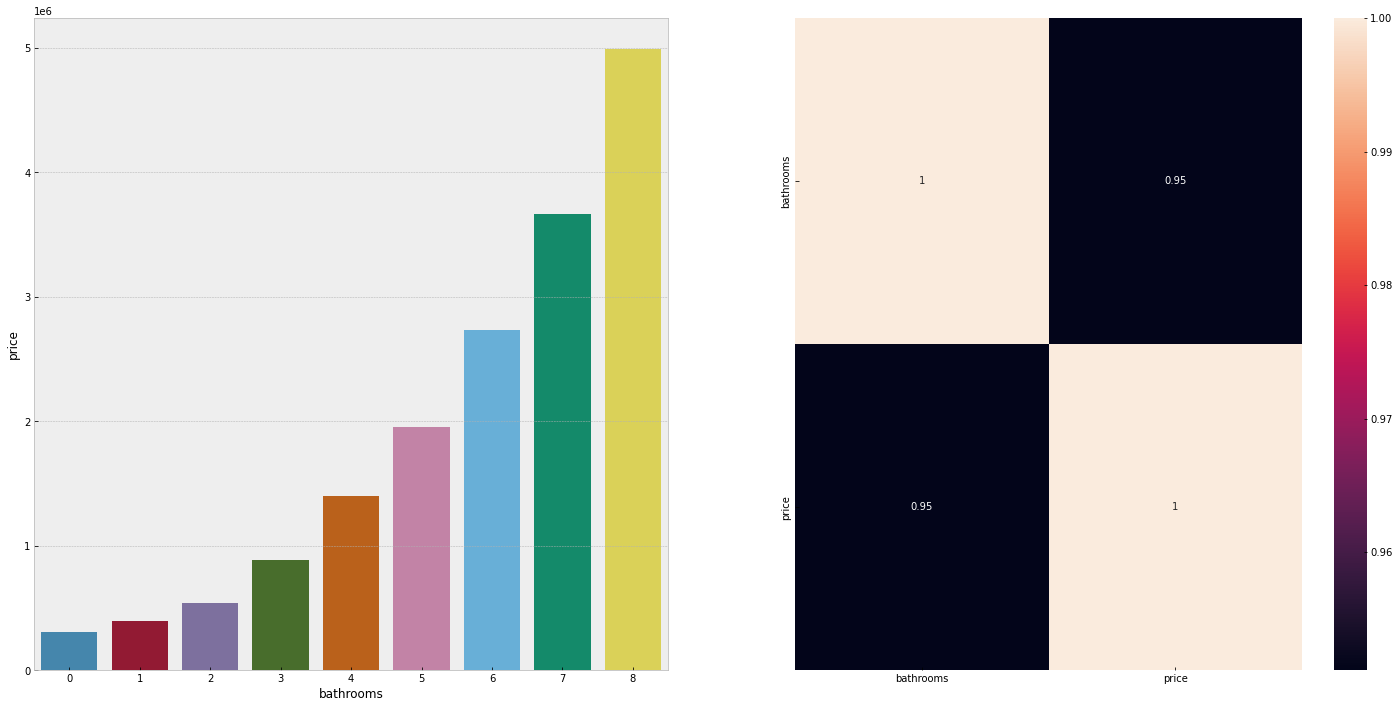

In [37]:
plt.subplot(1, 2, 1)
aux1 = df3[['bathrooms','price']].groupby('bathrooms').mean().reset_index()
sns.barplot(data=aux1, x='bathrooms', y='price');

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **2.** Casas com área de vivencia maior são mais caras na média
**Verdadeiro**

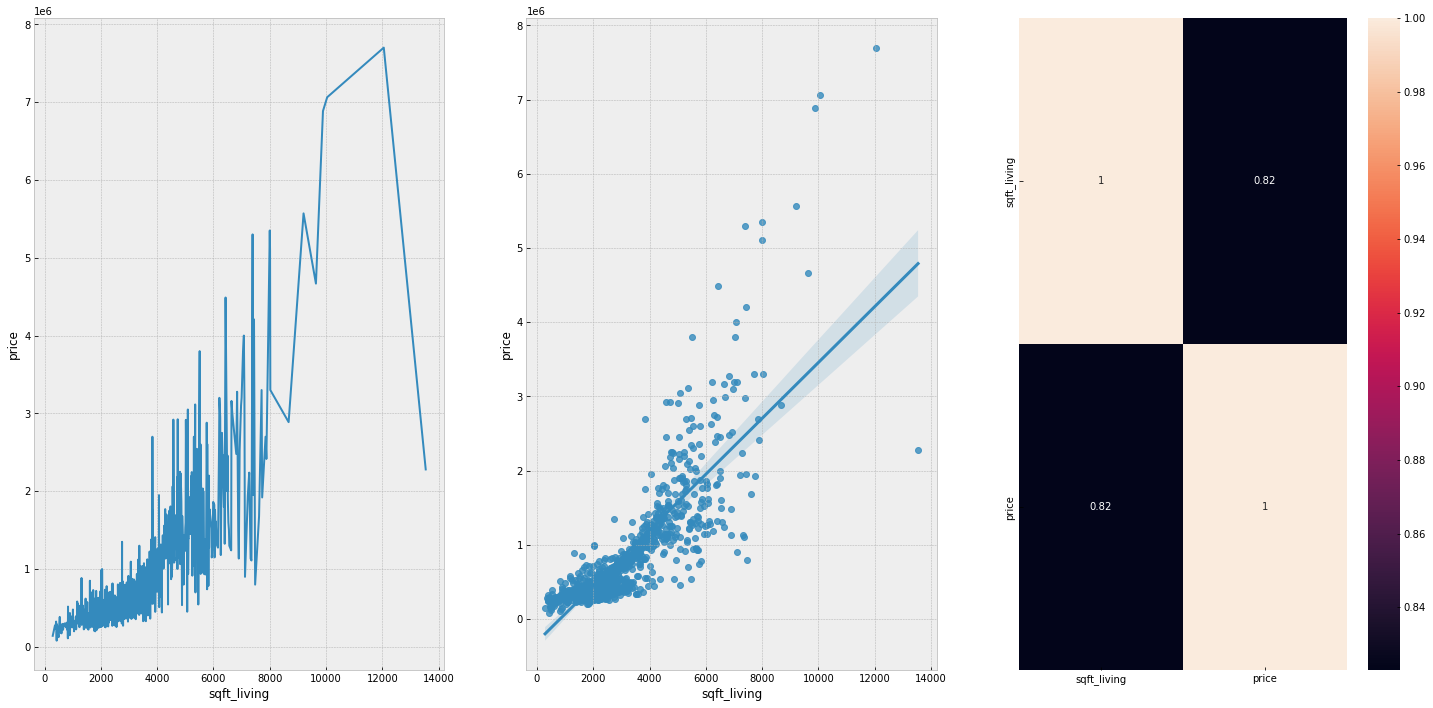

In [34]:
plt.subplot( 1, 3, 1 )
aux1 = df3[['sqft_living','price']].groupby('sqft_living').mean().reset_index()
sns.lineplot(data=aux1, x='sqft_living', y='price');

plt.subplot( 1, 3, 2 )
sns.regplot( x='sqft_living', y='price', data=aux1 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True )

### **3.** Casas com vista para água são 30% mais caras na média
**Verdadeiro**

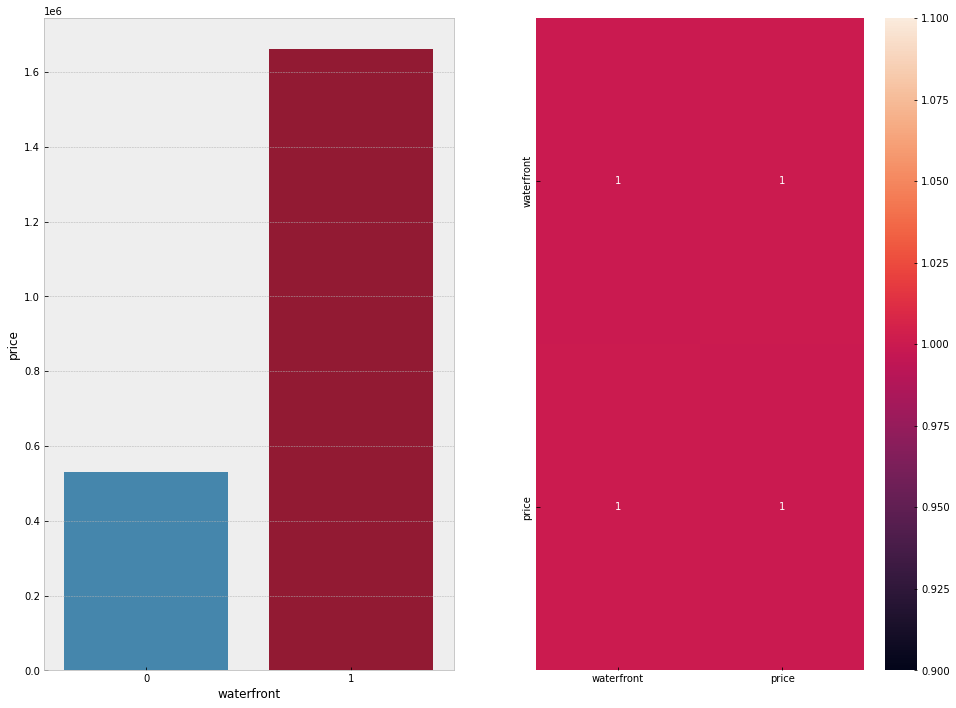

In [45]:
plt.subplot( 1, 3, 1 )
aux1 = df3[['waterfront','price']].groupby('waterfront').mean().reset_index()
sns.barplot(data=aux1, x='waterfront', y='price');

plt.subplot( 1, 3, 2 )
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)

### **4.** Casas com o tamanho do lote maior são mais caras.
**Falsa**

<AxesSubplot:>

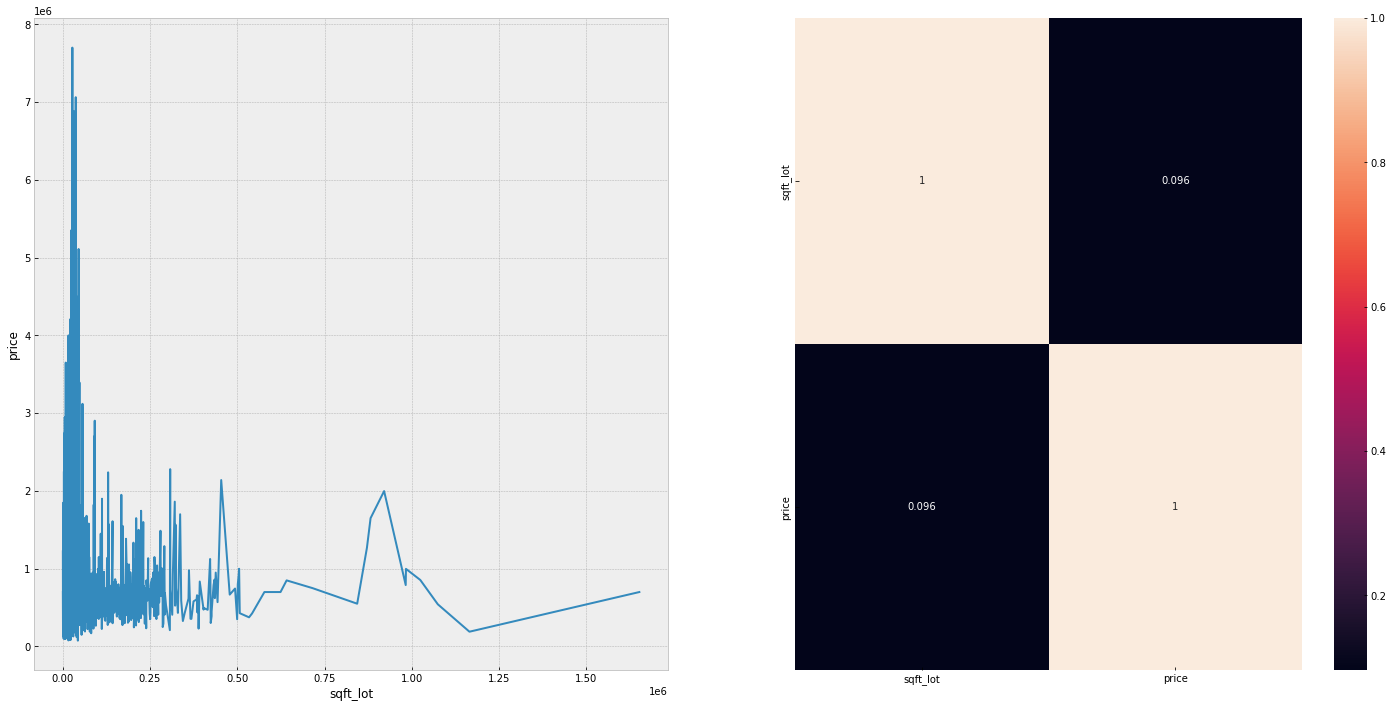

In [50]:
plt.subplot( 1, 2, 1 )
aux1 = df3[['sqft_lot','price']].groupby('sqft_lot').mean().reset_index()
sns.lineplot(data=aux1, x='sqft_lot', y='price');

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr(method='pearson'), annot=True )

### **5.** Casas com mais quartos são mais caras na média
**Falsa** - Casas com 8 quartos são as mais caras na média

<AxesSubplot:>

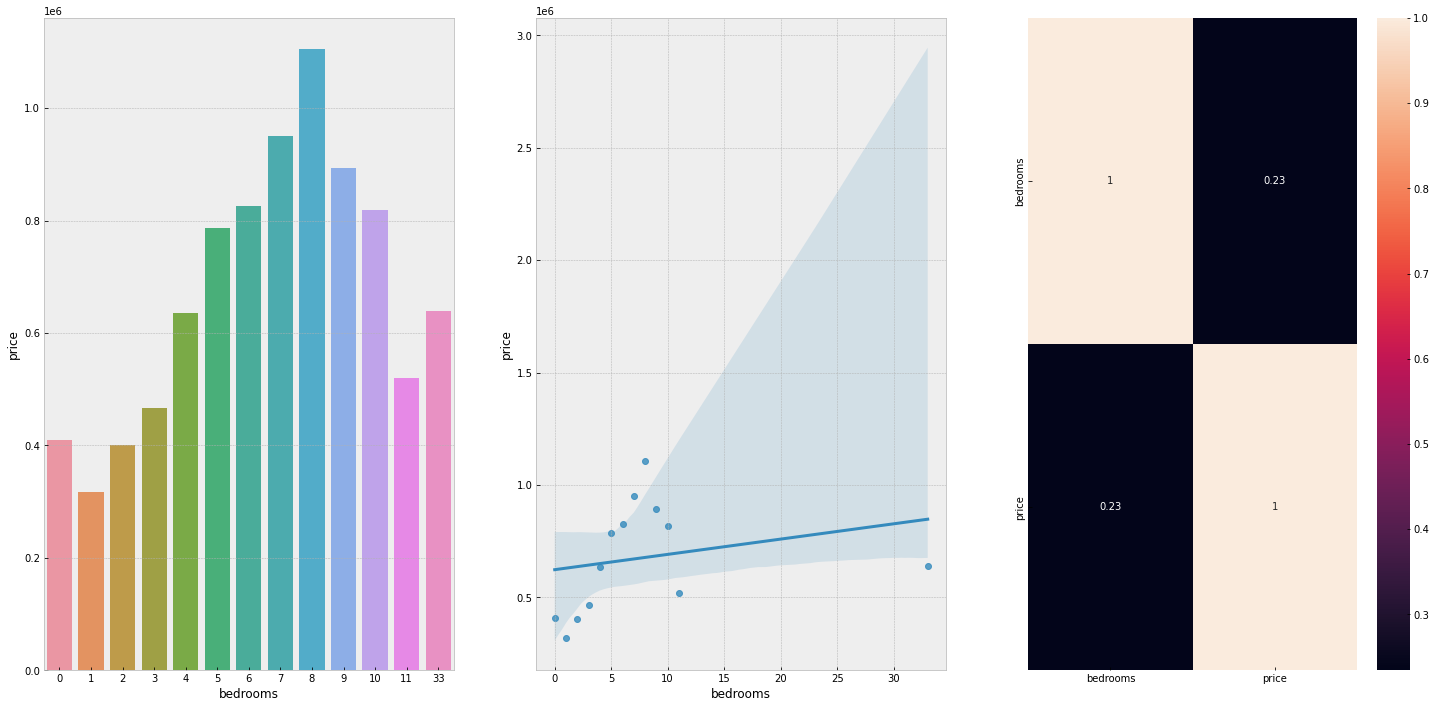

In [53]:
plt.subplot( 1, 3, 1 )
aux1 = df3[['bedrooms','price']].groupby('bedrooms').mean().reset_index()
sns.barplot(data=aux1, x='bedrooms', y='price');

plt.subplot( 1, 3, 2 )
sns.regplot( x='bedrooms', y='price', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr(method='pearson'), annot=True )


### **6.** Casas com a melhor condição são mais caras.
**Verdadeiro**

<AxesSubplot:>

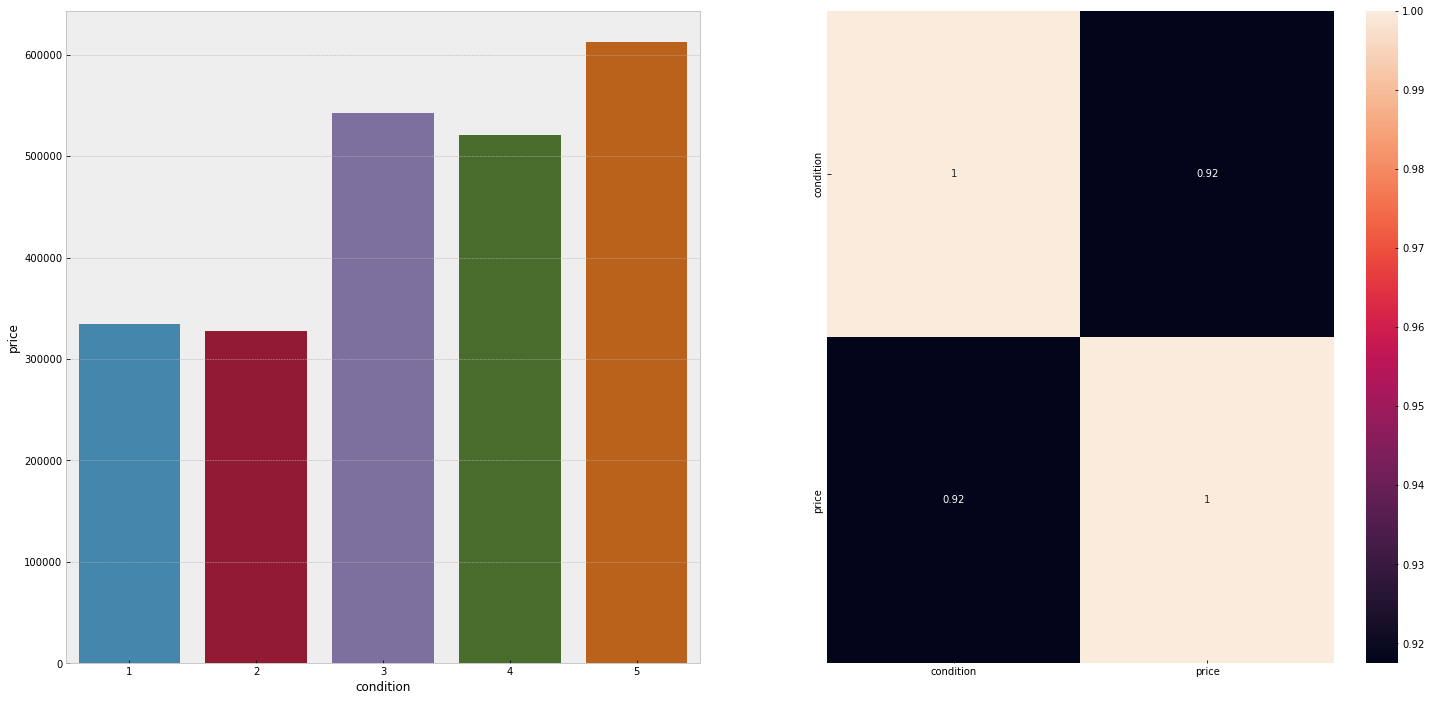

In [57]:
plt.subplot( 1, 2, 1 )
aux1 = df3[['condition','price']].groupby('condition').mean().reset_index()
sns.barplot(data=aux1, x='condition', y='price');

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr(method='pearson'), annot=True )

### **7.** Casas em áreas perto de rios ou lagos são mais caras.
As casas mais caras estão no zipcode de numero 98039 seguido da 98004 e 98040

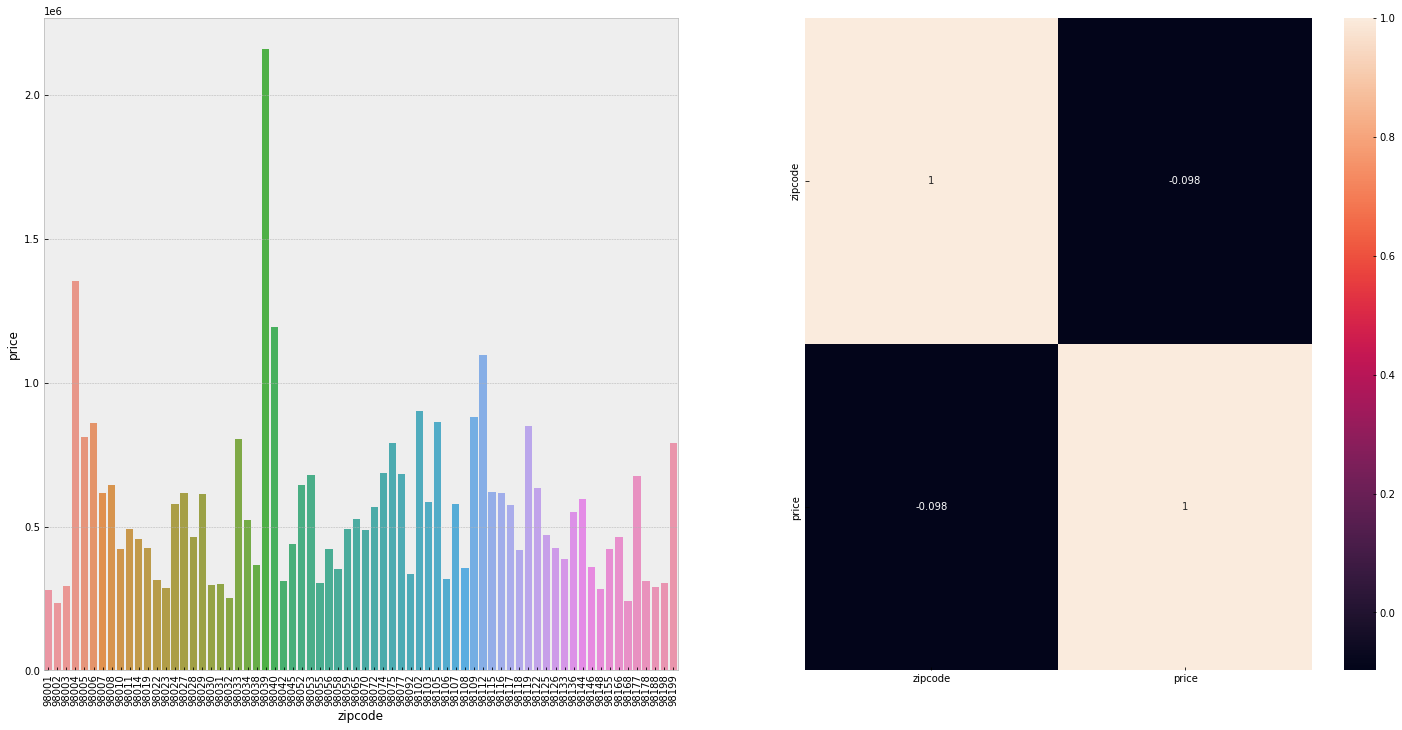

In [87]:
plt.subplot(1, 2, 1)
aux1 = df3[['zipcode','price']].groupby('zipcode').mean().reset_index()
sns.barplot(data=aux1, x='zipcode', y='price');
plt.xticks( rotation=90 );

plt.subplot(1, 2, 2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **8.** Casas mais afastadas do centro são mais baratas.
As casas mais baratas estão no zipcode numero 98002 seguido da 98168 e 98032

In [19]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
aux1 = df3[['zipcode','price']].groupby('zipcode').mean().sort_values(by='price', ascending=True).reset_index()
aux1

,zipcode,price
0,98002,234284.035
1,98168,240328.372
2,98032,251296.240
3,98001,280804.691
4,98148,284908.596
5,98023,286732.792
6,98188,289078.346
7,98003,294111.279
8,98030,296187.980
9,98031,300539.891


### **9.** Casas perto de escolas são mais caras.

### **10.** Casas durante o verão são mais caras
As casas são mais caras durante os meses de abril maio e junho que seriam os meses da primavera. E o mês onde as casas estão mais baratas é no mês de Fevereiro

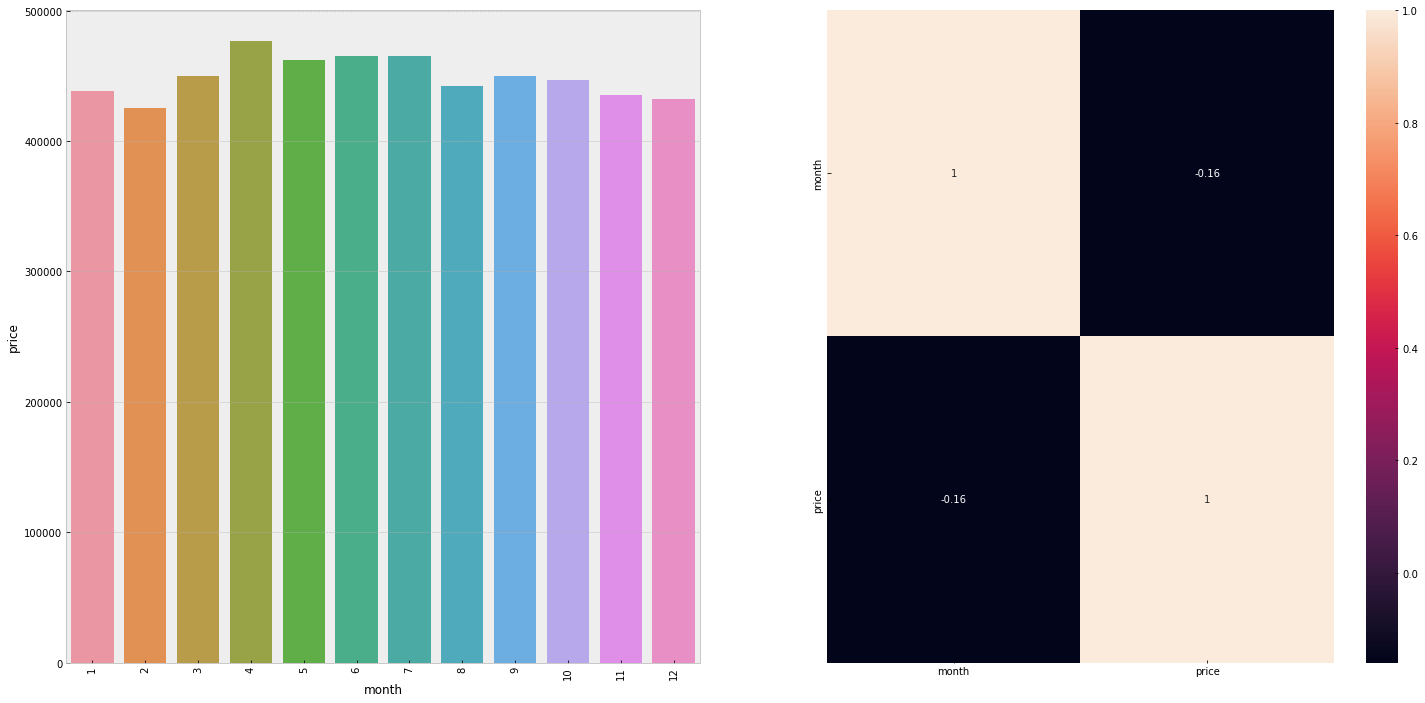

In [21]:
plt.subplot( 1, 2, 1 )
aux1 = df3[['month','price']].groupby('month').median().reset_index()
sns.barplot(data=aux1, x='month', y='price');
plt.xticks( rotation=90 );

plt.subplot( 1, 2, 2 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **11.** Casas valorizam 5% a cada ano.
**Falso** Casas se valorizam 0,55% a cada ano

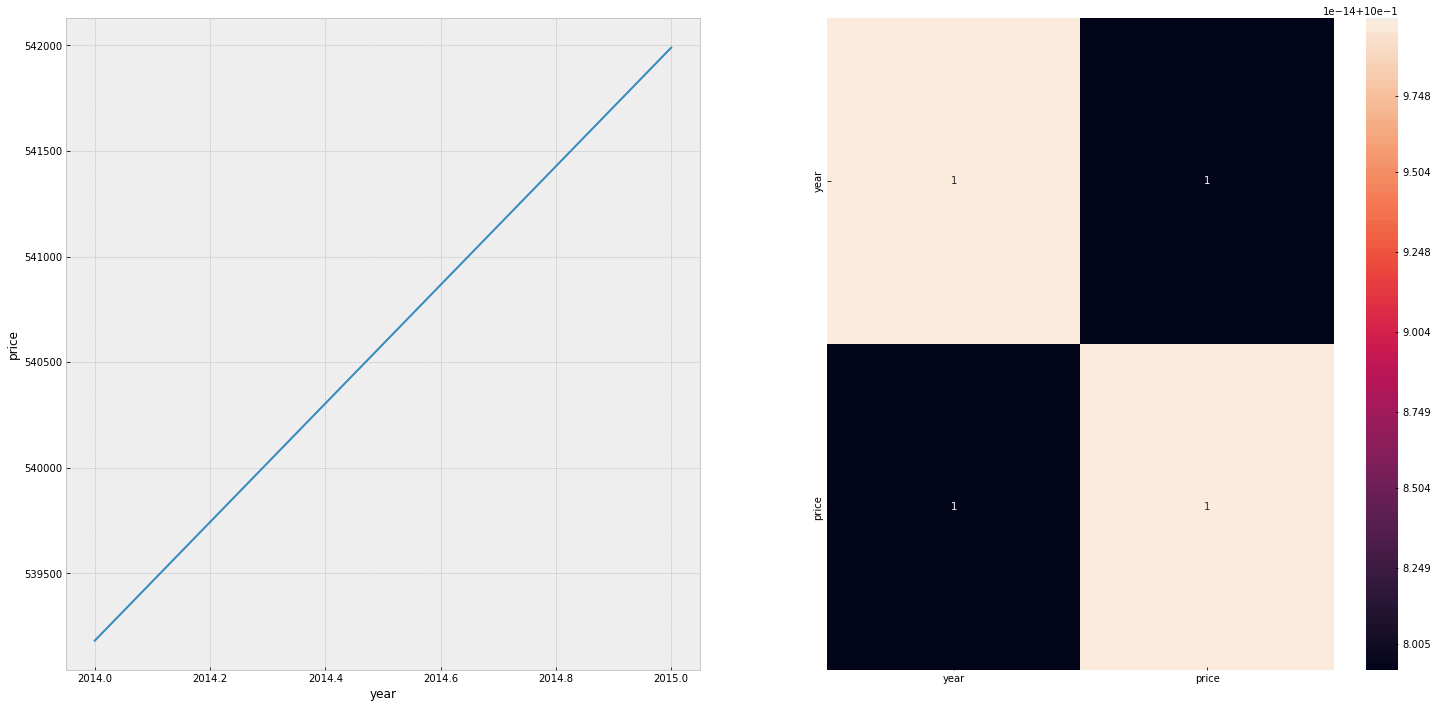

In [97]:
plt.subplot(1, 2, 1)
aux1 = df3[['year', 'price']].groupby('year').mean().reset_index()
sns.lineplot(data=aux1, x='year', y='price')

plt.subplot(1, 2, 2)
sns.heatmap( aux1.corr(method='pearson'), annot=True );

## 3.3 Análise Multivariada

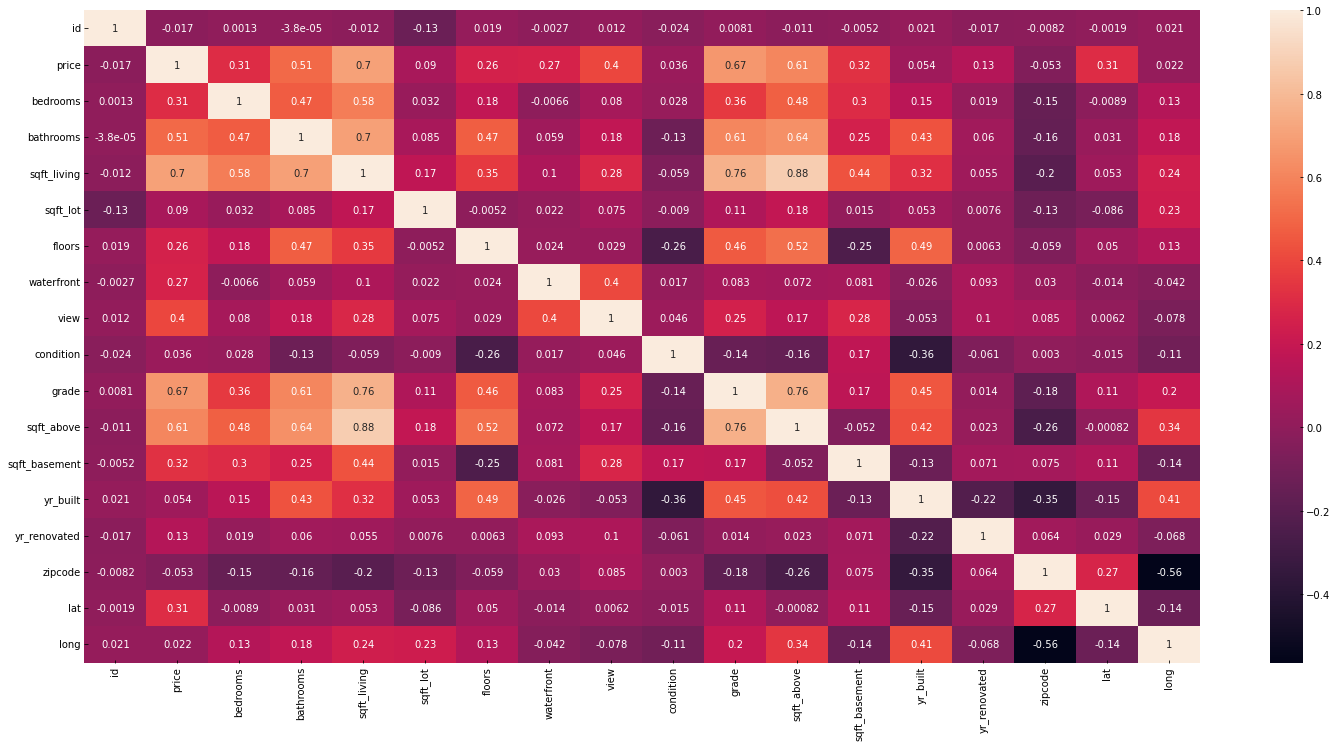

In [100]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 4.0 TABELA RECOMENDAÇÃO DE COMPRA

In [141]:
df4 = df3.copy()

In [109]:
# Variáveis que mais impactam o preço do imóvel:
# sqft_living, grade, sqft_above, bathrooms, view, sqft_basement
#
# Agrupar imóveis por zipcode e ver a mediana de preços

# Caso o imóvel tenha condição boa, com pelo menos 2 banheiros e preço abaixo da média
# farei uma recomedação de compra

In [142]:
# Taking the median price for each region
df_medians = df4[['zipcode', 'price']].groupby( 'zipcode' ).median().reset_index()

# Merging on the original dataset
df_merged = pd.merge( df4, df_medians, how='inner', on='zipcode' )

In [143]:
df_merged = df_merged.rename(columns={'price_x': 'selling_price', 'price_y': 'median_price'} )

In [144]:
# Number of houses to sell on each zipcode
df_houses = df_merged[['zipcode', 'id']].groupby('zipcode').count().reset_index().rename(columns={'id': 'houses_to_sell'})

In [145]:
df_final = pd.merge( df_merged, df_houses, how='inner', on='zipcode' )

In [146]:
# Creating filter for recomandation

buy_condition = [ ( (df_final['selling_price'] < df_final['median_price']) 
                  & (df_final['condition'] >= 3) 
                  & (df_final['bathrooms'] >= 1) ) ]

df_final['buy_suggestion'] = np.select(buy_condition, ['Yes'], default='No') 

df_final = df_final[['id', 'selling_price', 'bathrooms', 'condition', 'zipcode', 'houses_to_sell', 'buy_suggestion']]

In [147]:
# Creating column with the recommended price to buy: 
# From 0 to 204 properties in the region => Offer the asked price
# From 205 to 282 properties in the region => Offer 3% less than the asked price
# From 283 to 408 properties in the region => Offer 5% less than the asked price
# From 409 properties upwards => Offer 7% less than the asked price


suggested_price_conditions_buy = [((df_final['houses_to_sell'] <= 204) & (df_final['buy_suggestion']=='Yes')) , 
                                  ((df_final['houses_to_sell'] >= 205) & (df_final['houses_to_sell'] <= 282) & (df_final['buy_suggestion']=='Yes')),
                                  ((df_final['houses_to_sell'] >= 283) & (df_final['houses_to_sell'] <= 408) & (df_final['buy_suggestion']=='Yes')),
                                  ((df_final['houses_to_sell'] >= 409) & (df_final['buy_suggestion']=='Yes'))]


choicelist = [df_final['selling_price'], df_final['selling_price']*0.97, df_final['selling_price']*0.95, df_final['selling_price']*0.93]

df_final['suggested_buy_price'] = np.select(suggested_price_conditions_buy, choicelist, default='0')

In [150]:
df_final['suggested_buy_price'] = df_final['suggested_buy_price'].astype(  np.float64  )

In [151]:
# Creating column with the recommended price to sell: 
# From 0 to 204 properties in the region => Sell for 15% than the suggested buy price
# From 205 to 282 properties in the region => Sell for 14% than the suggested buy price
# From 283 to 408 properties in the region => Sell for 12% than the suggested buy price
# From 409 properties upwards => Sell for 10% than the suggested buy price
df_final['suggested_buy_price'] = pd.to_numeric(df_final['suggested_buy_price'])


suggested_price_conditions_sell =  [(df_final['houses_to_sell'] <= 204) , 
                                    (df_final['houses_to_sell'] >= 205) & (df_final['houses_to_sell'] <= 282),
                                    (df_final['houses_to_sell'] >= 283) & (df_final['houses_to_sell'] <= 408),
                                    (df_final['houses_to_sell'] >= 409)]
    
choicelist = [df_final['suggested_buy_price']*1.15, df_final['suggested_buy_price']*1.14, df_final['suggested_buy_price']*1.12, df_final['suggested_buy_price']*1.10]
    
df_final['suggested_sell_price'] = np.select(suggested_price_conditions_sell, choicelist)

df_final['profit'] = df_final['suggested_sell_price'] - df_final['suggested_buy_price']    

In [182]:
df_final = df_final.loc[ df_final['suggested_buy_price'] > 0, : ]
df_final.head()

,id,selling_price,bathrooms,condition,zipcode,houses_to_sell,buy_suggestion,suggested_buy_price,suggested_sell_price,profit
0,7129300520,221900.000,1,3,98178,262,Yes,215243.000,245377.020,30134.020
1,4060000240,205425.000,1,4,98178,262,Yes,199262.250,227158.965,27896.715
3,2976800796,236000.000,1,3,98178,262,Yes,228920.000,260968.800,32048.800
4,6874200960,170000.000,1,3,98178,262,Yes,164900.000,187986.000,23086.000
5,4268200055,245000.000,1,3,98178,262,Yes,237650.000,270921.000,33271.000


# Financial Results

In [194]:
df01 = df_final[['profit']].describe().drop(['count'])

In [195]:
total_profit = pd.DataFrame(df_final[['profit']].apply(np.sum)).rename(columns={0:'total'}).transpose()
median_profit = pd.DataFrame(df_final[['profit']].apply(np.median)).rename(columns={0:'median'}).transpose()

In [199]:
df_profit = pd.concat( [ df01, total_profit, median_profit  ] ).reindex(['total','mean','median','std','min','25%','50%','75%','max'])

In [200]:
df_profit

,profit
total,463714394.291
mean,44096.082
median,38595.000
std,21988.462
min,8044.500
25%,29465.887
50%,38595.000
75%,52511.250
max,282000.000
